In [21]:
# Load required Libraries
import numpy as np, pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import r2_score # To get the rsq score
import statsmodels.api as sm
from sklearn.feature_selection import RFE
#from sklearn.utils import check_arrays  # For MAPE calculation
from sklearn.preprocessing import PolynomialFeatures #For Polynomial LM
from sklearn.model_selection import cross_val_score #K-fold CV
import datetime
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format  # to suppress scientific notation

# -------------------Data Loading and Pre-processing-----------------------

In [22]:
# Read The data and get the overview
df = pd.read_csv("D:/Notes/Matt 891/Matt_imdb project/Web_Scrape_data.csv")
print(df.info()) # Summary of the data
print("------------------------------------------------")
print(df.head()) # small Part of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 11 columns):
title                         1732 non-null object
year                          1732 non-null object
certi                         1723 non-null object
time                          1723 non-null object
release_date                  1732 non-null object
rating                        1732 non-null float64
metascore                     1732 non-null object
budget                        1732 non-null object
Opening_Weekend_USA           1732 non-null object
Gross_USA                     1732 non-null object
Cumulative_Worldwide_Gross    1732 non-null object
dtypes: float64(1), object(10)
memory usage: 149.0+ KB
None
------------------------------------------------
                                              title  year  certi      time  \
0                                    Avatar (2009)   2009  PG-13  2h 42min   
1  Pirates of the Caribbean: At World's End (2007)   2007  PG-13  

In [23]:
# Data Cleaning
    # 1.Select movies released on and after the year 2000, this will help us reduce the effect of inflation. 
          #Remove observations with "-" in title, grossUSA and budget. Selecting USA movies
    # 2. Remove "," and "$" characters from the Multiple columns.
    # 3. Converting variables to required types.
    # 4. Converting the duration of movies from hr,min fromat to mins and then placing them as numeric form.
            # eg: "1h 48min" --> 108
    # 5. Converting the dates of movies from to months and then placing them as numeric form.
            # eg: "01 January 2011" --> 1 

# 1--------------------
df = df[df.title != "-"]     # Removing obs with "-" in it as the whole row for that obs has no data.
df = df[df.budget != "-"]    # Removing obs with "-" in it as Budget and Gross_USA is suspected to be a key variable to predict.
df = df[df.Gross_USA != "-"]   
df = df[df["release_date"].str.contains('USA')]
df["year"] = pd.to_numeric(df["year"])    # Converting to numeric as to apply the filter 
df = df[df.year >= 2000]               #   and select movies released in and after 2000

# 2--------------------
# Cleaning these colums as we want them to be quantitative variables.
cols_to_check = ['rating','metascore','budget','Opening_Weekend_USA', 'Gross_USA','Cumulative_Worldwide_Gross']
df[cols_to_check] = df[cols_to_check].replace({',':''}, regex=True)
df[cols_to_check] = df[cols_to_check].replace({'\$':''}, regex=True)
df[cols_to_check] = df[cols_to_check].replace({'-':''}, regex=True)

# 3--------------------
# Converting variables to integer types 

df["rating"] = pd.to_numeric(df["rating"])
df["metascore"] = pd.to_numeric(df["metascore"])
df["budget"] = pd.to_numeric(df["budget"])
df["Opening_Weekend_USA"] = pd.to_numeric(df["Opening_Weekend_USA"])
df["Gross_USA"] = pd.to_numeric(df["Gross_USA"])
df["Cumulative_Worldwide_Gross"] = pd.to_numeric(df["Cumulative_Worldwide_Gross"])

# 4--------------------
# Converting the duration of movies from hr,min fromat to mins and then placing them as numeric form.
            # eg: "1h 48min" --> 108

Runtime = list()
for i in range(len(df)):  # Itterating through all the "time" elements to convert them
    try:
        t = df.iloc[i, 3]
        l_t = t.split()
        l_t[0]= l_t[0].replace('h','')
        l_t[1]= l_t[1].replace('min','')
        a = (int(l_t[0])*60) + int(l_t[1])
        Runtime.append(a)
    except:
        Runtime.append("-")
        
df["Runtime"] = Runtime
df["Runtime"] = df["Runtime"].replace({'-':''}, regex=True)
df["Runtime"] = pd.to_numeric(df["Runtime"])      # Changing Runtime to int type

# 5--------------------
# Converting the dates of movies from to months and then placing them as numeric form.
            # eg: "01 January 2011" --> 1



Month = list()
for i in df["release_date"]:

    a = i[:-5]
    a=a.replace(" ", "")
    try:
        datee = datetime.datetime.strptime(a, "%d%B%Y")
        Month.append(datee.month)
    except:
        try:
            datee = datetime.datetime.strptime(a, "%B%Y")
            Month.append(datee.month)
        except:
            Month.append("")
            
df["Release_Month"] = Month
df["Release_Month"] = df["Release_Month"].astype('category',copy=False)

print(df.info()) # Summary of the data
print("------------------------------------------------")
print(df.head()) # small Part of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1731
Data columns (total 13 columns):
title                         1063 non-null object
year                          1063 non-null int64
certi                         1063 non-null object
time                          1063 non-null object
release_date                  1063 non-null object
rating                        1063 non-null float64
metascore                     765 non-null float64
budget                        1063 non-null int64
Opening_Weekend_USA           1063 non-null int64
Gross_USA                     1063 non-null int64
Cumulative_Worldwide_Gross    1063 non-null int64
Runtime                       1050 non-null float64
Release_Month                 1063 non-null category
dtypes: category(1), float64(3), int64(5), object(4)
memory usage: 149.4+ KB
None
------------------------------------------------
                                              title  year  certi      time  \
0                     

# ---------------------------Exploring the data (Visualization)-----------------------------------

### We will be understanding, processing and cleaning the data based on our findings

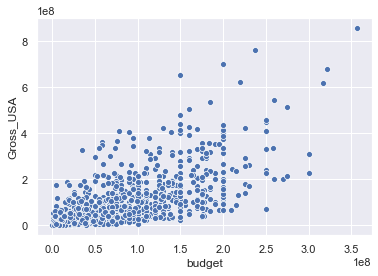

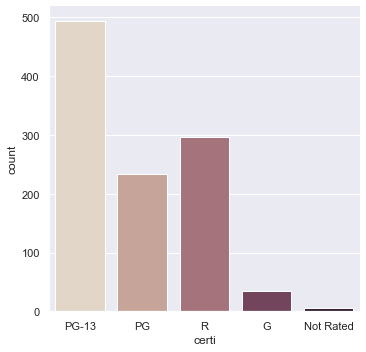

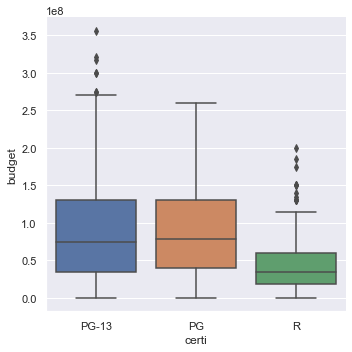

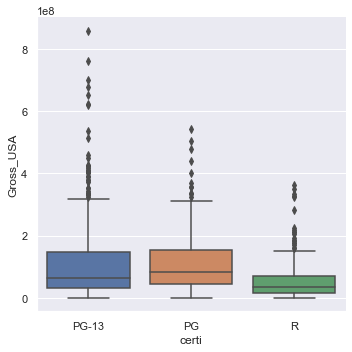

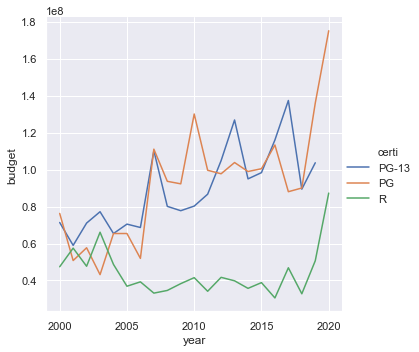

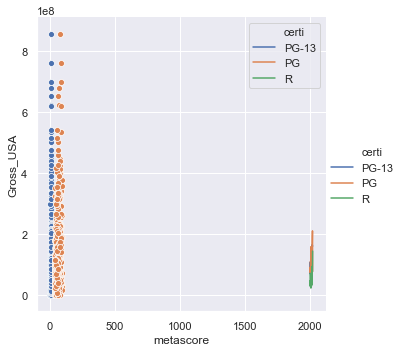

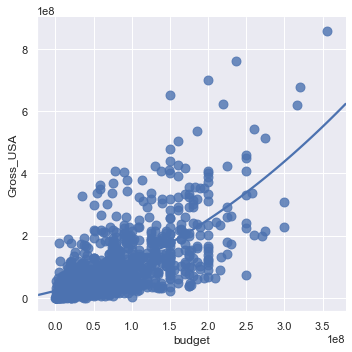

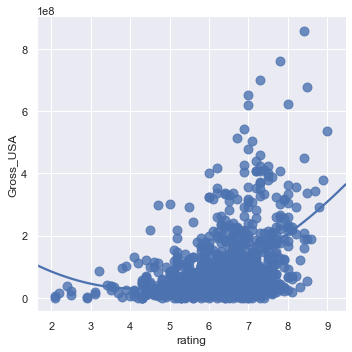

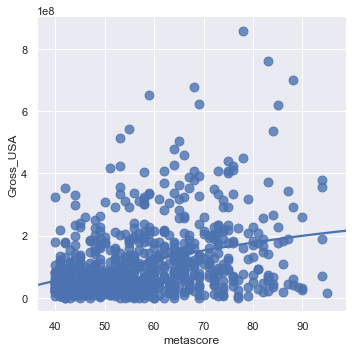

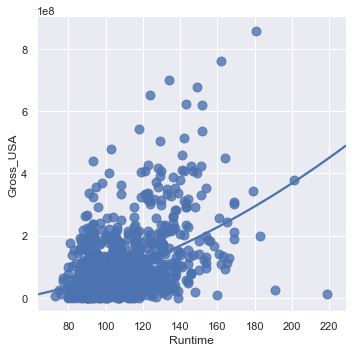

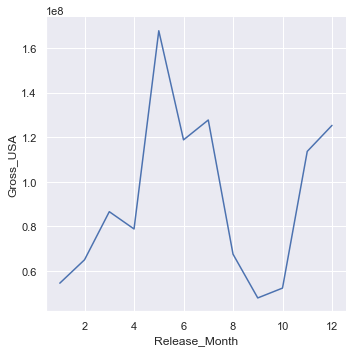

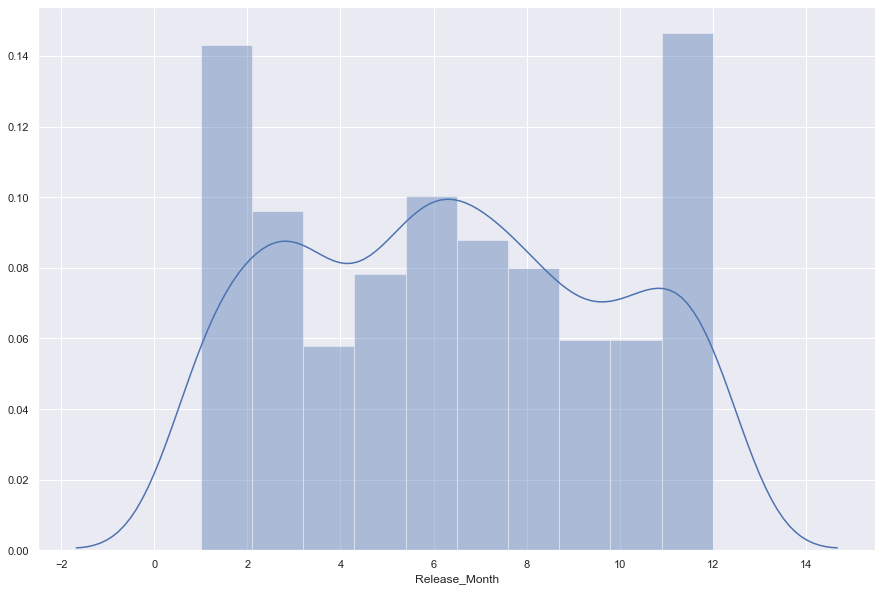

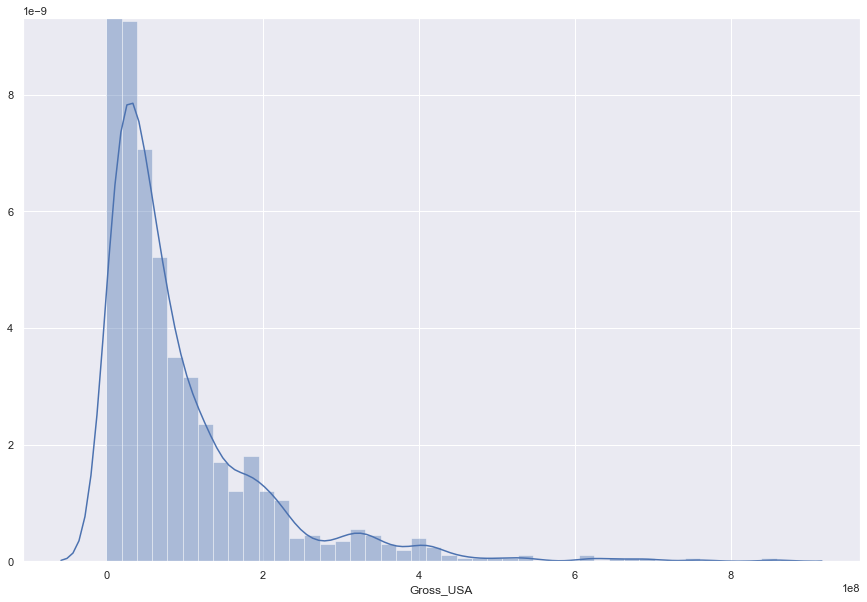

In [24]:
p1 = sns.scatterplot(x="budget", y="Gross_USA", data=df)  ## To observe Relationship between the variable budget and Gross_USA

p2 = sns.catplot(x="certi", kind="count", palette="ch:.25", data=df) ## Check distribution of movies accross different certification categories
# we can see that from the above chart that certifications "G" and "Not rated" amount for 40 count out of total observations.
                                                        #Thus we can exclude it as it forms just 4% of the data. 
df = df[df.certi != "Not Rated"]
df = df[df.certi != "G"]

# To check for outliers and understand the range of data colums
df["year"] = df["year"].astype('category',copy=False)
p3 = sns.catplot(x="certi", y="budget", kind="box", data=df)

p4 = sns.catplot(x="certi", y="Gross_USA", kind="box", data=df)

p5 = sns.relplot(x="year", y="budget", hue="certi",
            dashes=False, markers=True, ci=None, kind="line", data=df)

p6 = sns.relplot(x="year", y="Gross_USA", hue="certi",
            dashes=False, markers=True, ci=None, kind="line", data=df)

# we will be checking for gross_USA vs rating and metascore as there seems to be a relationship
p7 = sns.scatterplot(x="rating", y="Gross_USA", data=df)

p8 = sns.scatterplot(x="metascore", y="Gross_USA", data=df)

# to check if variables have linear relationship with Gross_USA or not
p9 = sns.lmplot(x="budget", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p10 = sns.lmplot(x="rating", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p11 = sns.lmplot(x="metascore", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})
p12 = sns.lmplot(x="Runtime", y="Gross_USA", data=df,
           order=2, ci=None, scatter_kws={"s": 80})

p13 = sns.relplot(x="Release_Month", y="Gross_USA",
            dashes=False, markers=True, ci=None, kind="line", data=df)

# Distribution of number of movies released each month
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df['Release_Month'])

# Distribution of Gross_USA
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df['Gross_USA'])

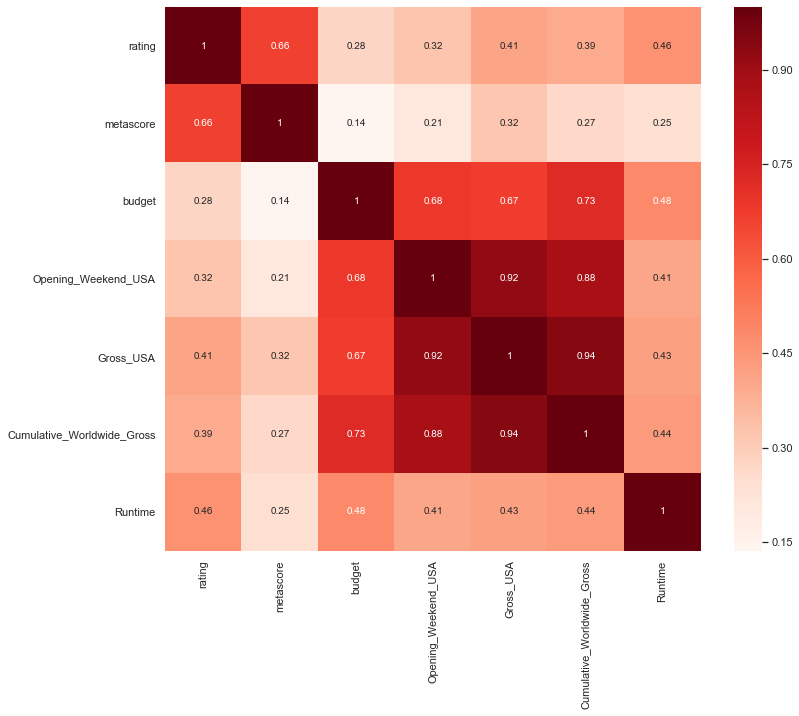

In [7]:
# Creating a corelation matrix of quantitative variables to understand how strong the variables are related with each other.
#df["year"] = pd.to_numeric(df["year"])
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### We can see that Opening_Weekend_USA and cumulative_Worldwide_gross have exceptionally high corelation value. This might create the effect of multicolinearity in the model. With help of some business understanding it is clear to us that Opening_Weekend_USA is part of Gross_USA and Gross_USA is part of cumulative_Worldwide_gross. Thus these are essentially categories of outcome variable and hence can be neglected.

### For other variables, 

In [7]:
#Correlation with output variable. Selecting variables based on corelation matrix

cor_target = abs(cor["Gross_USA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25 ]
relevant_features = relevant_features[relevant_features<0.9 ]
relevant_features

rating      0.41
metascore   0.30
budget      0.68
Runtime     0.43
Name: Gross_USA, dtype: float64

In [9]:
# Export Cleaned Data
df.to_csv("D:/Notes/Matt 891/Matt_imdb project/IMDBforR.csv")